In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from googleapiclient.discovery import build

In [2]:
from tqdm import tqdm_notebook

In [3]:
comments = list()
api_key = 'api key를 입력하시오.'
api_obj = build('youtube', 'v3', developerKey=api_key)

In [4]:
video_id = 'BSE9_bVYzhw'
video_id2 = 'wiB8GFFDxu8'

In [5]:
def find_time(strings):
    idx_start = strings.find('">')+2
    idx_end = strings.find('</a')
    if idx_start==1:
        return 
    else:
        time_string = strings[idx_start:idx_end]
        if 'http' not in time_string:
            return time_string
        else:
            return
def split_time_hour(x):
    if len(x.split(':'))==3:
        return x.split(':')[-3]
    else:
        return 0
def split_time_minute(x):
    return x.split(':')[-2]
def split_time_second(x):
    return x.split(':')[-1]

def transform_from_time(x):
    # 분:초로 구성
    hour = int(split_time_hour(x))
    minute = int(split_time_minute(x))
    second = int(split_time_second(x))
    return hour*3600+minute*60+second

def transform_to_time(x):
    minute = str(x//60)
    second = str(x%60)
    strings = '{}:{}'.format(minute,second.zfill(2))
    return strings

def plot_freq(grouped):
    grouped_input = grouped.copy()
    grouped_input['주목_시간'] = grouped_input['주목_시간'].map(transform_from_time)
    grouped_input['합'] = grouped_input['좋아요']+grouped_input['답글수']
    
    # 10초 단위로 합산해서 표현
    end_time = grouped_input['주목_시간'].iloc[-1]
    intervals = range(0,end_time+1,10)
    grouped_input['구간'] = pd.Categorical(pd.cut(grouped_input['주목_시간'],bins = intervals)).codes
    func_dict = {'주목_시간':'mean','합':'sum'}
    grouped_temp = grouped_input.groupby('구간').agg(func_dict)
    grouped_temp['주목_시간'] = grouped_temp['주목_시간'].round(0).astype(int)
    grouped_temp = grouped_temp.sort_values(by=['주목_시간'])
    
    x = grouped_temp['주목_시간'].tolist()
    y = grouped_temp['합'].tolist()
    plt.plot(x,y)
    if len(x)>15:
        show_interval = len(x)//15
    else:
        show_interval = 1
    plt.xticks(x[::show_interval],labels = pd.Series(x).map(transform_to_time).tolist()[::show_interval],rotation='90')
    
    

def generate_comment_df(video_id,api_key):
    # 대댓글은 포함되지 않는다.
    api_obj = build('youtube', 'v3', developerKey=api_key)

    comments = list()
    response = api_obj.commentThreads().list(part='snippet,replies', videoId=video_id, maxResults=100).execute()
        
    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            replycount = item['snippet']['totalReplyCount']
            comments.append([comment['authorDisplayName'], comment['publishedAt'], comment['likeCount'],replycount,comment['textDisplay']])
 
        if 'nextPageToken' in response:
            # 그다음 페이지 100개씩 받아옴
            response = api_obj.commentThreads().list(part='snippet,replies', videoId=video_id, pageToken=response['nextPageToken'], maxResults=100).execute()
        else:
            break
    df = pd.DataFrame(comments,columns = ['작성자','작성일시','좋아요','답글수','내용'])
        
    df['주목_시간'] = df['내용'].map(find_time)
    grouped = df.groupby('주목_시간').sum()[['좋아요','답글수']]
    if grouped.index[0] == '':
        grouped = grouped.drop(labels = '')            
    grouped_temp = grouped.reset_index()

    grouped_temp['분'] = grouped_temp['주목_시간'].map(split_time_minute).astype(int)
    grouped_temp['분'] += grouped_temp['주목_시간'].map(split_time_hour).astype(int)*60
    grouped_temp['초'] = grouped_temp['주목_시간'].map(split_time_second).astype(int)
    grouped_temp.sort_values(['분','초'],inplace=True)
    grouped_temp['주목_시간'] = grouped_temp['분'].astype('str')+':'+grouped_temp['초'].astype('str')
    grouped_temp.reset_index(drop=True,inplace=True)
    grouped_temp.drop(['분','초'],axis=1,inplace=True)
    return grouped_temp, df


In [9]:
grouped,df = generate_comment_df('qIinYt5nUII',api_key)
# GzHVBJGpJg8&t=107s -> GzHVBJGpJg8

In [10]:
df

,작성자,작성일시,좋아요,답글수,내용,주목_시간
0,김주원,2021-04-29T14:12:38Z,1,0,지나가는 이과생 : 절대 영도가 존재하니 한계가 존재하는 저온의 극복은 언젠간 가능...,None
1,김다복,2021-04-25T14:32:43Z,0,0,근데 왜 잘생김 침착맨 무슨 외국 배우같다,None
2,중간고사,2021-04-25T10:02:39Z,0,0,ㅋㅋㅋ아니 개웃기네 진짜 이 침펄 토론은 개쟈밌음,None
3,be hopely,2021-04-24T22:03:21Z,0,0,주호민님은 여름편이면서 트리를 왜 준비한고야ㅋㅋ,None
4,wish i,2021-04-19T09:39:58Z,0,0,사실상 겨울이면 식량이 없다..,None
...,...,...,...,...,...,...
1884,나승환,2018-11-17T09:28:24Z,791,15,"크리링, 복숭아, 문어, 전위, 주호민 하다하다가 태양 본인을 섭외하는 침착빨 인맥...",None
1885,다라다라고룬,2018-11-17T09:28:15Z,371,6,또 여름본인 등판하셨네,None
1886,우진,2018-11-17T09:27:45Z,0,0,썸네일 실화??,None
1887,Dawn,2018-11-17T09:27:36Z,78,0,만세 금요일에 하셔서 언제 나오나 기다렸는데 엄청 빨리 나오네욬ㅋㅋㅋㅋㅋㅋㅋ 기대 ...,None


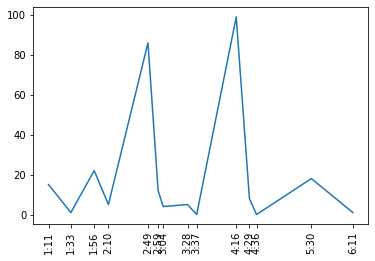

In [21]:
plot_freq(grouped)

- 두개의 영상이 있을 때 트리 형태로 묶을 수 있게 설계
- 여러 개의 영상 주소를 유투버에 따라 자동으로 가져오기
- 여러 유튜버를 다시 트리형태로 묶기
- 묶어진 트리 전체를 pickle 같은 것 이용해서 로컬에 저장

In [21]:
video_dict = {'우왁굳':['BSE9_bVYzhw','wiB8GFFDxu8','qpnXAE5dxQY'],'침착맨':['hnanNlDbsE4','UXb2DyR_2R4']}

In [22]:
list(video_dict.keys())

['우왁굳', '침착맨']

In [56]:
temp_dict = {}
for youtuber in tqdm_notebook(list(video_dict.keys())):
    temp_dict_youtuber = {}
    video_list = video_dict[youtuber]
    for video in tqdm_notebook(video_list):
        temp_dict_each_video = {}
        grouped, df = generate_comment_df(video,api_key)
        temp_dict_each_video['grouped'] = grouped
        temp_dict_each_video['df'] = df
        temp_dict_youtuber[video] = temp_dict_each_video
    temp_dict[youtuber] = temp_dict_youtuber

<ipython-input-56-7ffcefa765ea>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for youtuber in tqdm_notebook(list(video_dict.keys())):


<ipython-input-56-7ffcefa765ea>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for video in tqdm_notebook(video_list):


In [35]:
temp_dict.keys()

dict_keys(['우왁굳', '침착맨'])

In [36]:
temp_dict['침착맨'].keys()

dict_keys(['hnanNlDbsE4', 'UXb2DyR_2R4'])

In [93]:
aa = temp_dict['침착맨']['hnanNlDbsE4']['df']

In [97]:
aa.to_excel('rr.xlsx',index=False)

In [58]:
temp_dict['침착맨']['UXb2DyR_2R4']['grouped']

,주목_시간,좋아요,답글수
0,0:18,1,0
1,0:19,12,0
2,0:20,0,0
3,0:22,0,0
4,0:55,0,0
...,...,...,...
132,56:25,0,0
133,59:29,0,0
134,62:0,1,0
135,62:2,0,0


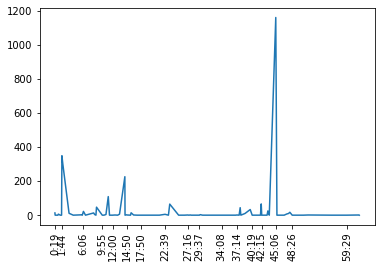

In [77]:
plot_freq(temp_dict['침착맨']['UXb2DyR_2R4']['grouped'])

3722


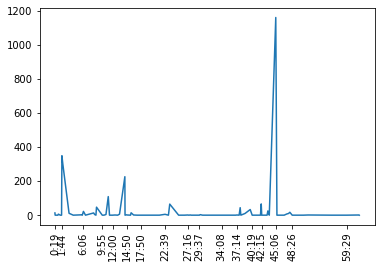

In [89]:
xx = plot_freq(temp_dict['침착맨']['UXb2DyR_2R4']['grouped'])

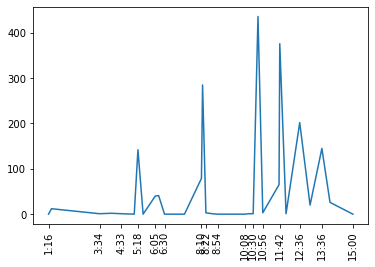

In [64]:
plot_freq(temp_dict['우왁굳']['qpnXAE5dxQY']['grouped'])

In [90]:
pd.Series(xx).map(transform_to_time)

0      0:19
1      0:22
2      0:55
3      1:01
4      1:24
      ...  
94    51:38
95    56:25
96    59:29
97    62:00
98    62:02
Length: 99, dtype: object

In [1]:
import pickle

In [109]:
with open('result0428.p','wb') as file:
    pickle.dump(temp_dict,file)

In [6]:
with open('result0428.p','rb') as file:
    data = pickle.load(file)

In [8]:
data.keys()

dict_keys(['우왁굳', '침착맨'])